### Multiclass classification on TREC data set using regular ML methods and Gaussian Processes

In [12]:
#import GPy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#from xgboost import plot_importance
from numpy import loadtxt
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import pickle
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt
#from pycaret.classification import *

In [2]:
import numpy as np
import tensorflow as tf

import warnings

warnings.filterwarnings("ignore")  # ignore DeprecationWarnings from tensorflow

import matplotlib.pyplot as plt

%matplotlib inline

import gpflow

from gpflow.utilities import print_summary, set_trainable
from gpflow.ci_utils import ci_niter

#from multiclass_classification import plot_posterior_predictions, colors

# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)

In [3]:
file_encoding = 'cp1252'

train_url = 'https://raw.githubusercontent.com/CS287/HW1/master/data/TREC.train.all'
test_url='https://raw.githubusercontent.com/CS287/HW1/master/data/TREC.test.all'
df_train = pd.read_csv(train_url,names=['code'],encoding=file_encoding)
df_test = pd.read_csv(test_url,names=['code'],encoding=file_encoding)
df_train[['label','text']] = df_train["code"].str.split(" ", 1,expand=True)
df_test[['label','text']] = df_train["code"].str.split(" ", 1,expand=True)
y_train=df_train["label"].astype(int)
y_test=df_test["label"].astype(int)

#### Pre Processing has been performed on original data set which includes Word 2 Vectorization. In this notebook we load the training and test data files which were pre processed.

In [4]:
X_train = np.load('X_train_TREC_google_w2v.npy')
#y_train = np.load('y_train_TREC.npy').astype(int)
X_test = np.load('X_test_TREC_google_w2v.npy')
#y_test = np.load('y_test_TREC.npy').astype(int)
data = (X_train, y_train)

### Sparse classification model is being built using RBF Kernel
Model is built and trained on entire training data set

In [7]:
# sum kernel: Matern32 + White
#kernel = gpflow.kernels.Matern32() + gpflow.kernels.White(variance=0.01)
C = 6
kernel = gpflow.kernels.RBF(1) + gpflow.kernels.White(variance=0.01)

# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(6, invlink=invlink)  # Multiclass likelihood
#Z = X_train[::5].copy()  # inducing inputs
Z = X_train.copy()
m = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=Z,
    num_latent_gps=C,
    whiten=True,
    q_diag=True,
)

# Only train the variational parameters
set_trainable(m.kernel.kernels[1].variance, False)
set_trainable(m.inducing_variable, False)
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(5452, 300)",float64,"[[-0.01367188, -0.05543518, 0.05633545..."
SVGP.q_mu,Parameter,Identity,,True,"(5452, 6)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,Softplus,,True,"(5452, 6)",float64,"[[1., 1., 1...."


### Optimising the model
Iterations are set to 100

In [8]:

%%time

opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(
    m.training_loss_closure(data), m.trainable_variables, options=dict(maxiter=ci_niter(100))
)
print_summary(m, fmt="notebook")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,8.178570195394908
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.1175047537180147
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(5452, 300)",float64,"[[-0.01367188, -0.05543518, 0.05633545..."
SVGP.q_mu,Parameter,Identity,,True,"(5452, 6)",float64,"[[0.21308333, 1.66236041, -2.84084028..."
SVGP.q_sqrt,Parameter,Softplus,,True,"(5452, 6)",float64,"[[0.09938862, 0.11620512, 0.6887989..."


CPU times: user 2h 25min 38s, sys: 11min 4s, total: 2h 36min 43s
Wall time: 28min 42s


### Predictions, Accuracy calculation & Plotting Confusion Matrix on Test data

In [9]:
pred_probas=m.predict_y(X_test)
test=pred_probas[0].numpy()
###convert multi class probabilities in to labels 
res=[]

C=6
N=len(test)
for i in range(N):
    d=0   
    for j in range(C):
        if test[i][j]>d:
            d=test[i][j]
            k=j
        else:
            continue
    res.append(k)

In [10]:
accuracy = accuracy_score(y_test,res )
#print("accuracy:",accuracy)
print('Test Accuracy: {:.2%}'.format(accuracy))

Test Accuracy: 93.40%


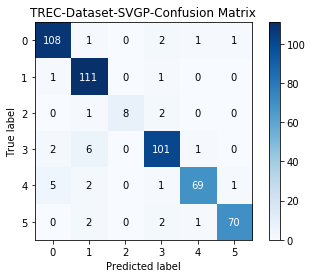

In [13]:
skplt.metrics.plot_confusion_matrix(y_test, res)
plt.title("TREC-Dataset-SVGP-Confusion Matrix")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

### Predictions, Accuracy calculation & Plotting Confusion Matrix on Training data

In [14]:
pred_probas=m.predict_y(X_train)
test=pred_probas[0].numpy()

###convert multi class probabilities in to labels 
res=[]

C=6
N=len(test)
for i in range(N):
    d=0   
    for j in range(C):
        if test[i][j]>d:
            d=test[i][j]
            k=j
        else:
            continue
    res.append(k)
tr_accuracy = accuracy_score(y_train,res )
print("train accuracy:",tr_accuracy)

train accuracy: 0.9180117388114454


Train Accuracy: 91.80%


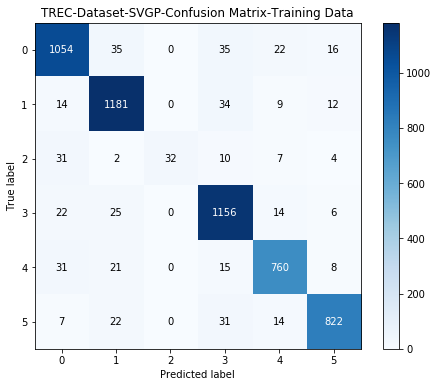

In [15]:
print('Train Accuracy: {:.2%}'.format(tr_accuracy))
#cm=confusion_matrix(y_train, res)
#print("confusion matrix:\n",cm)
skplt.metrics.plot_confusion_matrix(y_train, res)
plt.title("TREC-Dataset-SVGP-Confusion Matrix-Training Data")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

### Training the sparse classification model using centroids as inducing points.
K-Means clustering is performed on data set to generate centroids.


In [26]:
from scipy import cluster
M = 5000
Z, distortion = cluster.vq.kmeans(X_train,M)

In [27]:
# sum kernel: Matern32 + White
#kernel = gpflow.kernels.Matern32() + gpflow.kernels.White(variance=0.01)
kernel = gpflow.kernels.RBF(1) + gpflow.kernels.White(variance=0.01)

# Robustmax Multiclass Likelihood
invlink = gpflow.likelihoods.RobustMax(C)  # Robustmax inverse link function
likelihood = gpflow.likelihoods.MultiClass(6, invlink=invlink)  # Multiclass likelihood
#Z = X[::5].copy()  # inducing inputs

m = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=Z,
    num_latent_gps=C,
    whiten=True,
    q_diag=True,
)

# Only train the variational parameters
set_trainable(m.kernel.kernels[1].variance, False)
set_trainable(m.inducing_variable, False)
print_summary(m, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(4822, 300)",float64,"[[0.04860433, 0.09200033, 0.09309896..."
SVGP.q_mu,Parameter,Identity,,True,"(4822, 6)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,Softplus,,True,"(4822, 6)",float64,"[[1., 1., 1...."


In [28]:
%%time
opt = gpflow.optimizers.Scipy()

opt_logs = opt.minimize(
    m.training_loss_closure(data), m.trainable_variables, options=dict(maxiter=ci_niter(100))
)
print_summary(m, fmt="notebook")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,7.5749572964949845
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.140132147599324
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SVGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(4822, 300)",float64,"[[0.04860433, 0.09200033, 0.09309896..."
SVGP.q_mu,Parameter,Identity,,True,"(4822, 6)",float64,"[[2.24137044e-01, 3.33543604e+00, -6.14901779e+00..."
SVGP.q_sqrt,Parameter,Softplus,,True,"(4822, 6)",float64,"[[0.00225029, 0.0177524, 0.43096538..."


CPU times: user 1h 55min 51s, sys: 9min 42s, total: 2h 5min 33s
Wall time: 22min 50s


### Predictions, Accuracy calculation & Plotting Confusion Matrix on centroids trained model

In [29]:
pred_probas=m.predict_y(X_test)
test=pred_probas[0].numpy()
###convert multi class probabilities in to labels 
res=[]

C=6
N=len(test)
for i in range(N):
    d=0   
    for j in range(C):
        if test[i][j]>d:
            d=test[i][j]
            k=j
        else:
            continue
    res.append(k)
        

In [30]:
accuracy = accuracy_score(y_test,res )
print('Test Accuracy: {:.2%}'.format(accuracy))

Test Accuracy: 90.40%


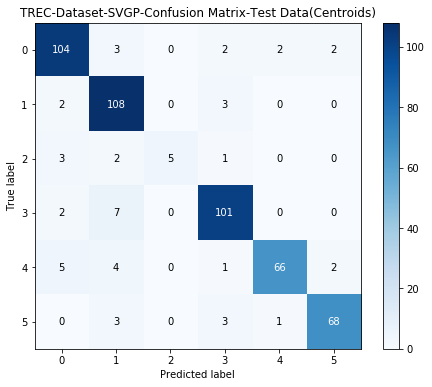

In [31]:
skplt.metrics.plot_confusion_matrix(y_test, res)
plt.title("TREC-Dataset-SVGP-Confusion Matrix-Test Data(Centroids)")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

### Training Accuracy

In [32]:
pred_probas=m.predict_y(X_train)
test=pred_probas[0].numpy()

###convert multi class probabilities in to labels 
res_tr=[]

C=6
N=len(test)
for i in range(N):
    d=0   
    for j in range(C):
        if test[i][j]>d:
            d=test[i][j]
            k=j
        else:
            continue
    res_tr.append(k)
tr_accuracy = accuracy_score(y_train,res_tr )
print('Train Accuracy: {:.2%}'.format(tr_accuracy))

Train Accuracy: 90.17%


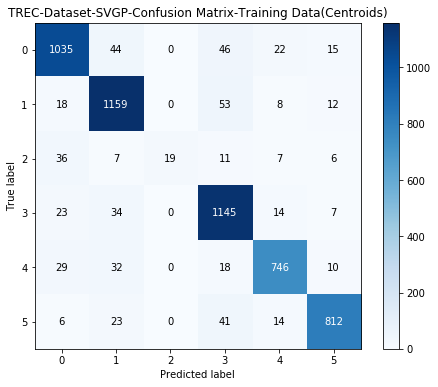

In [33]:
skplt.metrics.plot_confusion_matrix(y_train, res_tr)
plt.title("TREC-Dataset-SVGP-Confusion Matrix-Training Data(Centroids)")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

## Evaluating the performance of regular machine learning models
### Neural networks

In [204]:

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Dropout,LSTM,Embedding,SimpleRNN, GRU,Activation,Flatten
from tensorflow.keras.layers import Conv1D,MaxPool1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger
from tensorflow.keras.utils import plot_model
#from keras.utils import from tensorflow.keras.utils import
#from tensorflow.keras.utils import  np_utils
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import (precision_score, recall_score,confusion_matrix,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
import pandas as pd
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
import scikitplot as skplt
#import scikitplot as skplt

In [243]:
test_size = 0.33
X_t, X_val, y_t, y_va = train_test_split(X_train, y_train, test_size=test_size, random_state=3)

In [245]:
X_tr = np.reshape(X_t, (X_t.shape[0], 1, X_t.shape[1]))
X_tst = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#X_val= np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [246]:
y_tr=y = y_train.ravel()
y_tst=y_test.ravel()
y_val=y_va.ravel()

In [247]:
y_tr = tf.keras.utils.to_categorical(y_t, num_classes=6)
y_tst= tf.keras.utils.to_categorical(y_test, num_classes=6)
y_val= tf.keras.utils.to_categorical(y_val, num_classes=6)

In [249]:
batch_size = 64
id=X_train.shape[1]
# define network
model_dnn3 = Sequential()
model_dnn3.add(Flatten())
model_dnn3.add(Dense(1024,input_dim=id,activation='relu'))  
model_dnn3.add(Dropout(0.01))
model_dnn3.add(Dense(768,activation='relu'))  
model_dnn3.add(Dropout(0.01))
model_dnn3.add(Dense(6, activation='softmax'))
# model_dnn3.add(Dense(6))
# model_dnn3.add(Activation('softmax'))

In [252]:

model_dnn3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001,patience=5) ## early stoppoing

model_dnn3.fit(X_tr, y_tr, validation_data=(X_val, y_val),batch_size=batch_size, epochs=1000, callbacks=[es])
#model_dnn3.fit(X_tr, y_train,batch_size=batch_size, epochs=1000, callbacks=[es])
#model_dnn3.save("dnn_two_layer_model_dnn3.hdf5")

Epoch 1/1000
58/58 [==============================] - 1s 11ms/step - loss: 1.4277 - accuracy: 0.4159 - val_loss: 1.0520 - val_accuracy: 0.6022
Epoch 2/1000
58/58 [==============================] - 1s 9ms/step - loss: 0.8582 - accuracy: 0.6722 - val_loss: 0.9825 - val_accuracy: 0.6422
Epoch 3/1000
58/58 [==============================] - 1s 9ms/step - loss: 0.6780 - accuracy: 0.7563 - val_loss: 0.9651 - val_accuracy: 0.6700
Epoch 4/1000
58/58 [==============================] - 0s 9ms/step - loss: 0.4888 - accuracy: 0.8396 - val_loss: 1.0388 - val_accuracy: 0.6678
Epoch 5/1000
58/58 [==============================] - 1s 13ms/step - loss: 0.3757 - accuracy: 0.8745 - val_loss: 1.1048 - val_accuracy: 0.6594
Epoch 6/1000
58/58 [==============================] - 1s 9ms/step - loss: 0.2239 - accuracy: 0.9413 - val_loss: 1.2086 - val_accuracy: 0.6750
Epoch 7/1000
58/58 [==============================] - 1s 9ms/step - loss: 0.1708 - accuracy: 0.9502 - val_loss: 1.3573 - val_accuracy: 0.6494
Epoc

In [259]:

y_pred_dnn3 = model_dnn3.predict_classes(X_tst)
y_pred_train= model_dnn3.predict_classes(X_tr)
#y_probs_dnn3=model_dnn3.predict_proba(X_test)
#np.savetxt('dnn3_predictions.txt', np.transpose(np.concatenate((y_test.reshape((y_test.size, 1)),y_pred_dnn3), axis=1)), fmt='%01d')
#np.savetxt('dnn3_prob_predictions.txt', np.around(np.transpose(y_probs_dnn3),decimals=5), fmt='%.5f')

### Accuracy calculation & Plotting confusion matrix

In [262]:
accuracy_test = accuracy_score(y_test, y_pred=y_pred_dnn3)
accuracy_train = accuracy_score(y_t, y_pred=y_pred_train)
print("test accuracy:",accuracy_test*100,"%")

print("train accuracy:",accuracy_train*100,"%")
#cm=confusion_matrix(y_test, y_pred=y_pred_dnn3)
#print("confusion matrix:\n",cm)


test accuracy: 90.2 %
train accuracy: 99.12376779846659 %


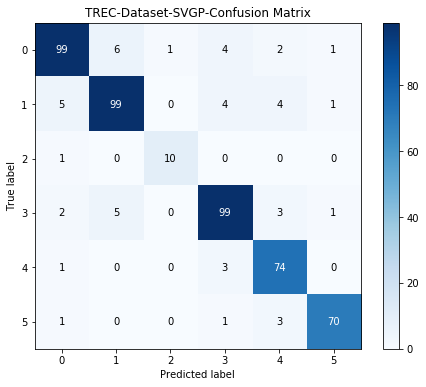

In [258]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_dnn3)
plt.title("TREC-Dataset-NN-Confusion Matrix")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

## Logistic regression 

In [16]:
model_lr=LogisticRegression(C=0.1,random_state=0)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
y_prob_lr = model_lr.predict_proba(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred_lr)
#print("accuracy:",accuracy)
print('Test Accuracy: {:.2%}'.format(accuracy))

# f1score=f1_score(y_test, y_pred_lr)
# print("f1-acore:",f1score)

Test Accuracy: 68.00%


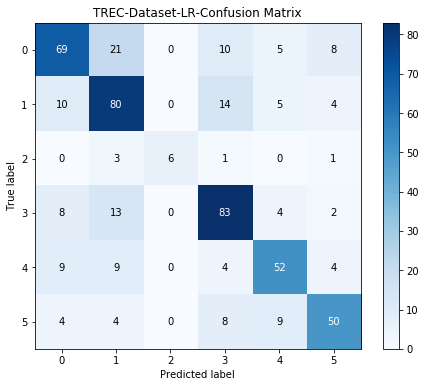

In [18]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_lr)
plt.title("TREC-Dataset-LR-Confusion Matrix")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

In [19]:
y_pred_lr = model_lr.predict(X_train)
y_prob_lr = model_lr.predict_proba(X_train)
tr_accuracy = accuracy_score(y_train, y_pred_lr)
print('Train Accuracy: {:.2%}'.format(tr_accuracy))

Train Accuracy: 66.43%


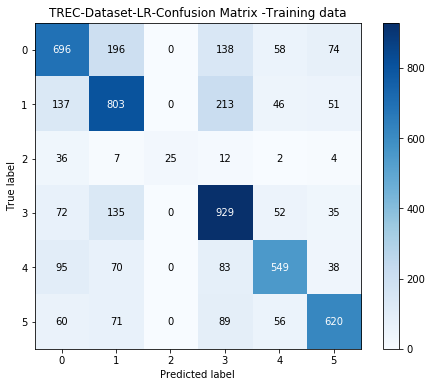

In [20]:
skplt.metrics.plot_confusion_matrix(y_train, y_pred_lr)
plt.title("TREC-Dataset-LR-Confusion Matrix -Training data")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

## Naive Bayes

In [21]:
%%time
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
#from sklearn.neighbors import KNeighborsClassifier
model_nb=BernoulliNB()
#model_nb=GaussianNB()
model_nb.fit(X_train, y_train)
#y_pred = model_nb.predict(X_test_nb)
y_pred_nb = model_nb.predict(X_test)
y_prob_nb = model_nb.predict_proba(X_test)

CPU times: user 238 ms, sys: 9.09 ms, total: 247 ms
Wall time: 43 ms


In [22]:
accuracy = accuracy_score(y_test, y_pred_nb)
print('Test Accuracy: {:.2%}'.format(accuracy))

Test Accuracy: 55.60%


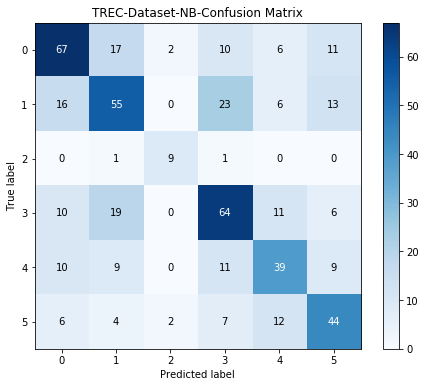

In [23]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_nb)
plt.title("TREC-Dataset-NB-Confusion Matrix")
plt.rcParams['figure.figsize']=(8,6)
plt.show()

In [24]:
y_pred_nb = model_nb.predict(X_train)
y_prob_nb = model_nb.predict_proba(X_train)
tr_accuracy = accuracy_score(y_train, y_pred_nb)
print('Train Accuracy: {:.2%}'.format(tr_accuracy))

Train Accuracy: 56.07%


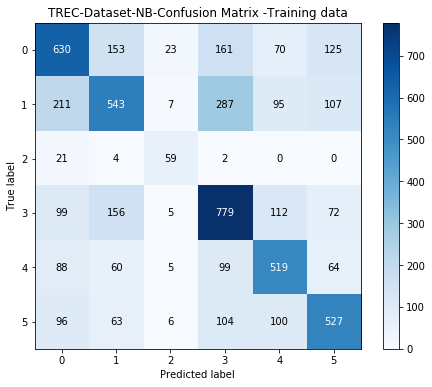

In [25]:
skplt.metrics.plot_confusion_matrix(y_train, y_pred_nb)
plt.title("TREC-Dataset-NB-Confusion Matrix -Training data")
plt.rcParams['figure.figsize']=(8,6)
plt.show()